In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import scipy
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Load scRNA-seq and spatial data from our model

In [ ]:
data_id = "embryo"
our_spatial = anndata.read_loom(f"./results/{data_id}/imputeFormer_ST_{data_id}.loom", var_names='var_names', obs_names="obs_names")
our_seq = anndata.read_loom(f"./results/{data_id}/imputeFormer_SC_{data_id}.loom", var_names='var_names', obs_names="obs_names")

In [4]:
X = our_spatial.obsm["latent_val"]
y = our_spatial.obsm["spatial"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
class spatial_data:
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            if scale_data:
                X = StandardScaler().fit_transform(X)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
train_dataset = spatial_data(X_train, y_train, scale_data=False)
test_dataset = spatial_data(X_test, y_test, scale_data=False)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=24)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=24)

In [10]:
mlp = MLP()

loss_function = nn.L1Loss(reduction="sum")
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [11]:
def eval_mlp(model, testloader):
    model.eval()
    loss_function = nn.L1Loss(reduction="sum")

    test_loss = 0.0
    n_obs = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            X, y = data
            outputs = model(X)
            loss = loss_function(outputs, y)

            n_batch = len(y)
            n_obs += n_batch
            test_loss += loss.item()
    test_loss /= n_obs

    return test_loss

In [12]:
record_train_loss = []
record_test_loss = []
epochs = 100

for epoch in range(0,epochs):
    current_loss = 0.0
    n_obs = 0
    
    for i, data in enumerate(trainloader):
        inputs, targets = data
        
        optimizer.zero_grad()

        outputs = mlp(inputs)

        loss = loss_function(outputs, targets)

        loss.backward()
        optimizer.step()
        
        n_batch = len(targets)
        n_obs += n_batch
        current_loss += loss.item()

    current_loss /= n_obs
    record_train_loss.append(current_loss)
    test_loss = eval_mlp(mlp, testloader)
    record_test_loss.append(test_loss)
    print(f'Epoch: %d | Training Loss: %.5f, Testing loss: %.5f'%(epoch+1, current_loss, test_loss))

print("Training has completed")

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1 | Training Loss: 2.18945, Testing loss: 1.87415
Epoch: 2 | Training Loss: 1.75413, Testing loss: 1.63770
Epoch: 3 | Training Loss: 1.56019, Testing loss: 1.51257
Epoch: 4 | Training Loss: 1.44395, Testing loss: 1.43989
Epoch: 5 | Training Loss: 1.36233, Testing loss: 1.31264
Epoch: 6 | Training Loss: 1.35586, Testing loss: 1.41868
Epoch: 7 | Training Loss: 1.31701, Testing loss: 1.26894
Epoch: 8 | Training Loss: 1.29146, Testing loss: 1.25935
Epoch: 9 | Training Loss: 1.28623, Testing loss: 1.23846
Epoch: 10 | Training Loss: 1.26990, Testing loss: 1.25722
Epoch: 11 | Training Loss: 1.26209, Testing loss: 1.24786
Epoch: 12 | Training Loss: 1.25570, Testing loss: 1.21218
Epoch: 13 | Training Loss: 1.23508, Testing loss: 1.24287
Epoch: 14 | Training Loss: 1.23521, Testing loss: 1.20696
Epoch: 15 | Training Loss: 1.21474, Testing loss: 1.20607
Epoch: 16 | Training Loss: 1.21264, Testing loss: 1.21741
Epoch: 17 | Training Loss: 1.20608, Testing loss: 1.20013
Epoch: 18 | Training Lo

### Visualization training and testing loss during model training

In [13]:
from matplotlib import cm, colors
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager # to solve: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
import json

centimeter = 1/2.54  # centimeter in inches

# https://www.geeksforgeeks.org/react-js-blueprint-colors-qualitative-color-schemes/
react_cols_10 = ['#147EB3','#29A634','#D1980B','#D33D17','#9D3F9D','#00A396','#DB2C6F','#8EB125','#946638','#7961DB']

# http://tsitsul.in/blog/coloropt/
norm_7 = ['#4053d3','#ddb310','#b51d14','#00beff','#fb49b0','#00b25d','#cacaca']
norm_12 = ['#ebac23','#b80058','#008cf9','#006e00','#00bbad','#d163e6','#b24502',
           '#ff9287','#5954d6','#00c6f8','#878500','#00a76c','#bdbdbd']

def config_rc(dpi=400, font_size=6, lw=1.):
    # matplotlib.rcParams.keys()
    rc={
        'font.size': font_size, 
        'axes.labelsize': font_size, 
        'axes.titlesize': font_size, 
        'xtick.labelsize': font_size, 
        'ytick.labelsize': font_size,
        'figure.dpi':dpi,'axes.linewidth':lw,
        'legend.markerscale': 0.8, 
        'legend.markerscale': 0.8, 
        'legend.loc': 'upper right',
        'legend.borderpad':0.2,
        'legend.columnspacing': 0.5,
        'legend.labelspacing': 0.2,
        'legend.handletextpad': 0.1,
        'legend.borderaxespad': 0.1,
        'legend.handleheight': 1.0,
        'legend.handlelength': 1.0,
    } # 'figure.figsize':(11.7/1.5,8.27/1.5)
    
    sns.set(style='ticks',rc=rc) 
    sns.set_context("paper")

    mpl.rcParams.update(rc)

    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42

    #mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.unicode_minus']=False # negative minus sign

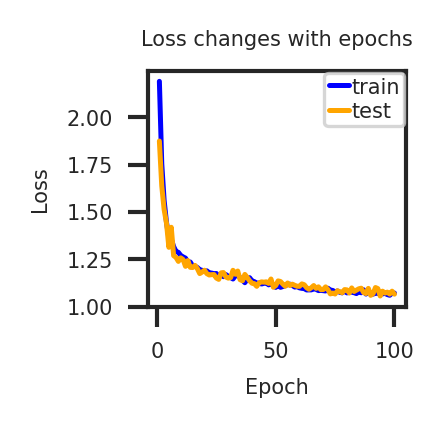

In [14]:
config_rc(dpi=300, font_size=5)

fig, ax = plt.subplots(1,1, figsize=(3.5*centimeter,3.5*centimeter))

n_epochs = list(range(1, epochs+1))
ax.plot(n_epochs, record_train_loss, color="blue", label="train")
ax.plot(n_epochs, record_test_loss, color="orange", label="test")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(fontsize="medium")
ax.set_title('Loss changes with epochs')

fig.tight_layout()

### Visualization the infered spatial position in scRNA-seq cells

In [15]:
X_test = our_seq.obsm['latent_val']

pos_sc = mlp(torch.from_numpy(X_test))

In [16]:
our_seq.obsm["spatial"] = pos_sc.detach().numpy()

In [17]:
pos_st = mlp(torch.from_numpy(X))
pos_st = pos_st.detach().numpy()
our_spatial.obsm["infer_spatial"] = pos_st

In [18]:
_palette = {'Allantois': '#1CE6FF',
 'Anterior somitic tissues': '#FF34FF',
 'Blood progenitors': '#FF4A46',
 'Cardiomyocytes': '#008941',
 'Caudal Mesoderm': '#006FA6',
 'Cranial mesoderm': '#A30059',
 'Def. endoderm': '#FFDBE5',
 'Dermomyotome': '#7A4900',
 'Endothelium': '#0000A6',
 'Erythroid': '#63FFAC',
 'ExE endoderm': '#B79762',
 'ExE mesoderm': '#004D43',
 'Forebrain/Midbrain/Hindbrain': '#8FB0FF',
 'Gut': '#997D87',
 'Haematoendothelial progenitors': '#5A0007',
 'Intermediate mesoderm': '#809693',
 'Lateral plate mesoderm': '#6A3A4C',
 'Low quality': '#1B4400',
 'Mesenchyme': '#4FC601',
 'NMP': '#3B5DFF',
 'Neural crest': '#4A3B53',
 'Notochord': '#FF2F80',
 'PGC': '#61615A',
 'Paraxial mesoderm': '#BA0900',
 'Pharyngeal mesoderm': '#6B7900',
 'Rostral neurectoderm': '#00C2A0',
 'Sclerotome': '#FFAA92',
 'Somitic mesoderm': '#FF90C9',
 'Spinal cord': '#B903AA',
 'Surface ectoderm': '#D16100',
 'Visceral endoderm': '#DDEFFF'}

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


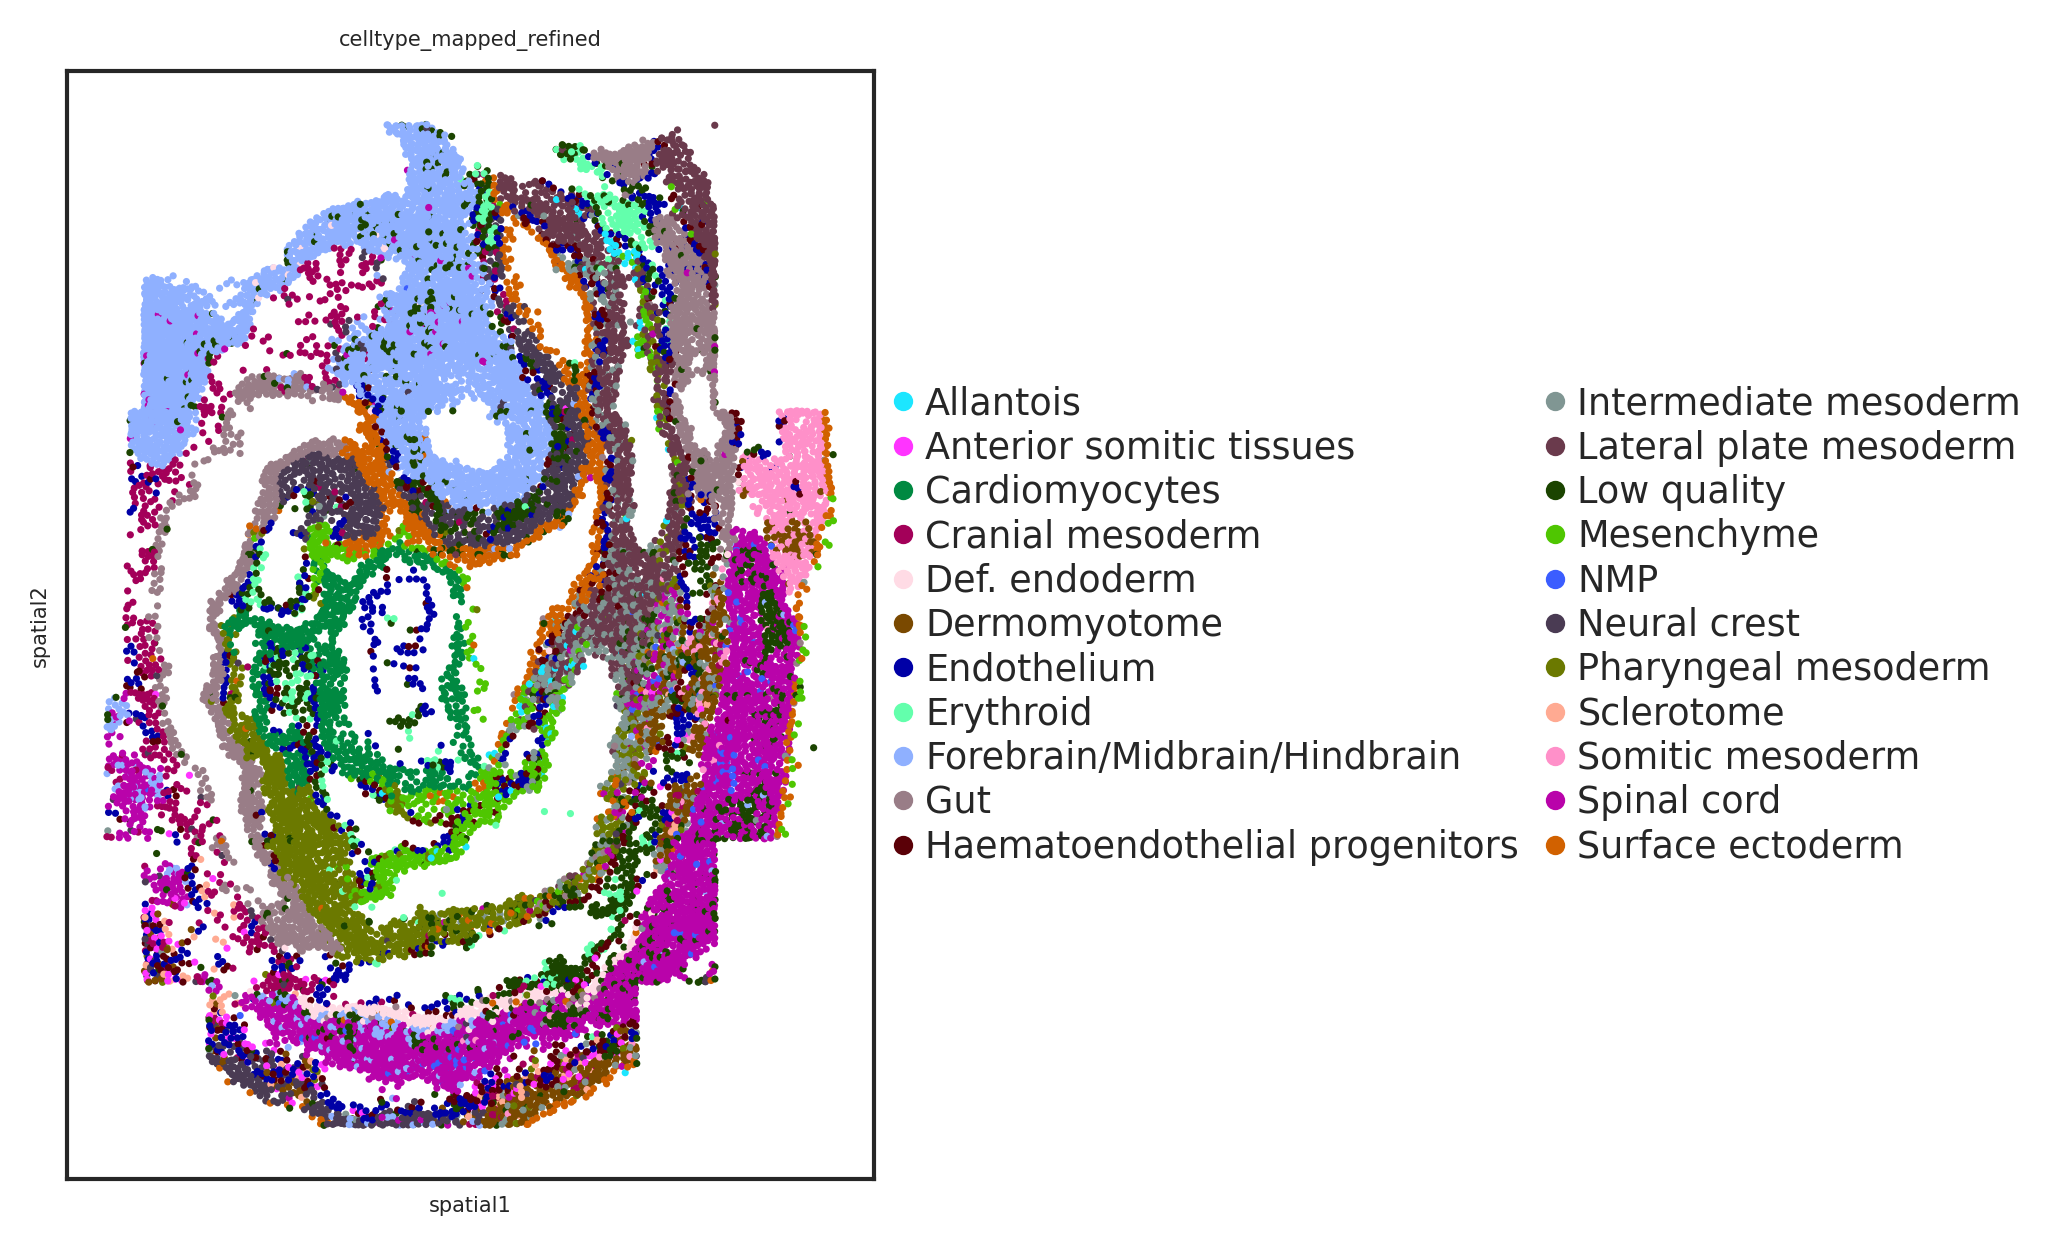

In [19]:
st_change = {'Presomitic mesoderm': "Somitic mesoderm", 'Splanchnic mesoderm': "Pharyngeal mesoderm", 'Definitive endoderm': 'Def. endoderm',
            'Gut tube': "Gut", 'Mixed mesenchymal mesoderm': "Mesenchyme"}
our_spatial.obs["celltype_mapped_refined"] = our_spatial.obs["celltype_mapped_refined"].replace(st_change)
sc.pl.spatial(our_spatial, color="celltype_mapped_refined", palette=_palette, spot_size=0.05)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


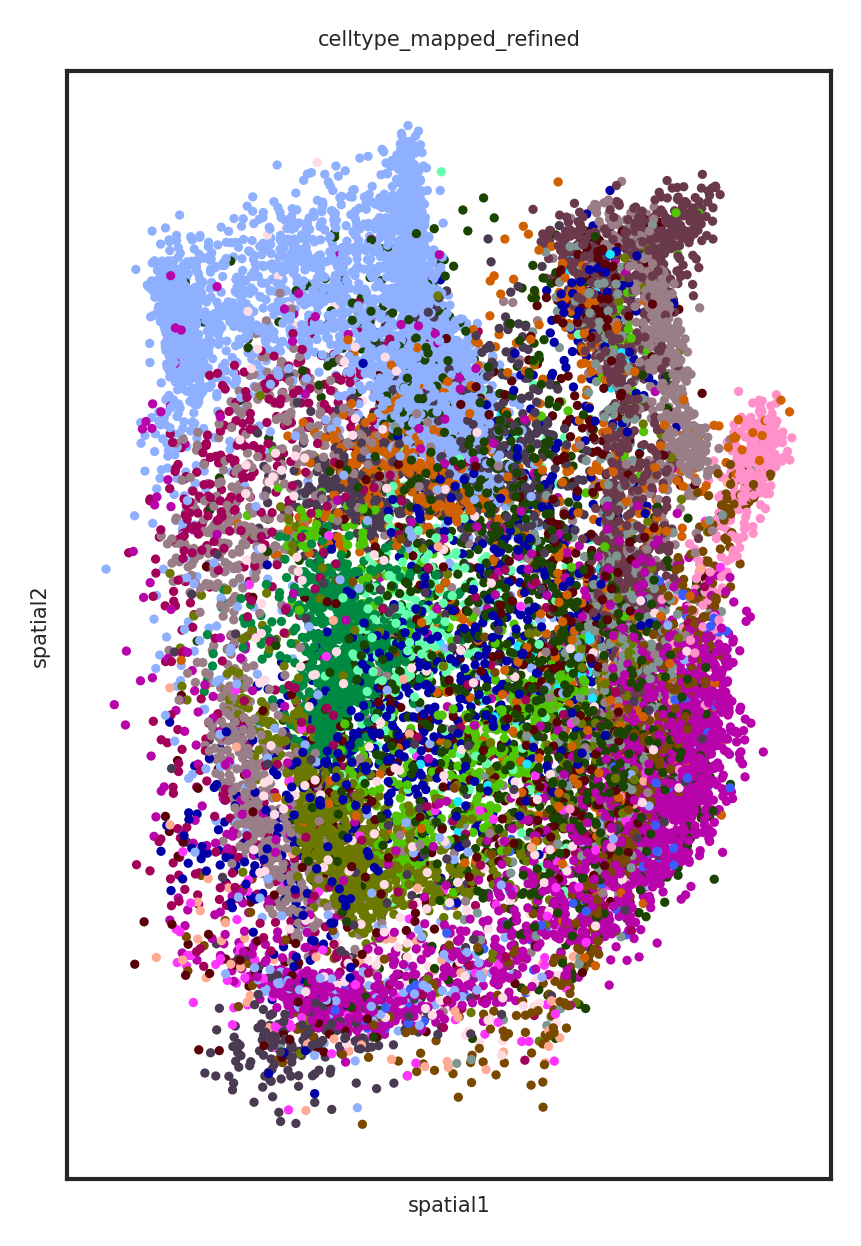

In [20]:
our_spatial.obsm["raw_spatial"] = our_spatial.obsm["spatial"]
our_spatial.obsm["spatial"] = our_spatial.obsm["infer_spatial"]
sc.pl.spatial(our_spatial, color="celltype_mapped_refined", palette=_palette, spot_size=0.07, legend_loc=None)

/datacommons/carin/xg103/software/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


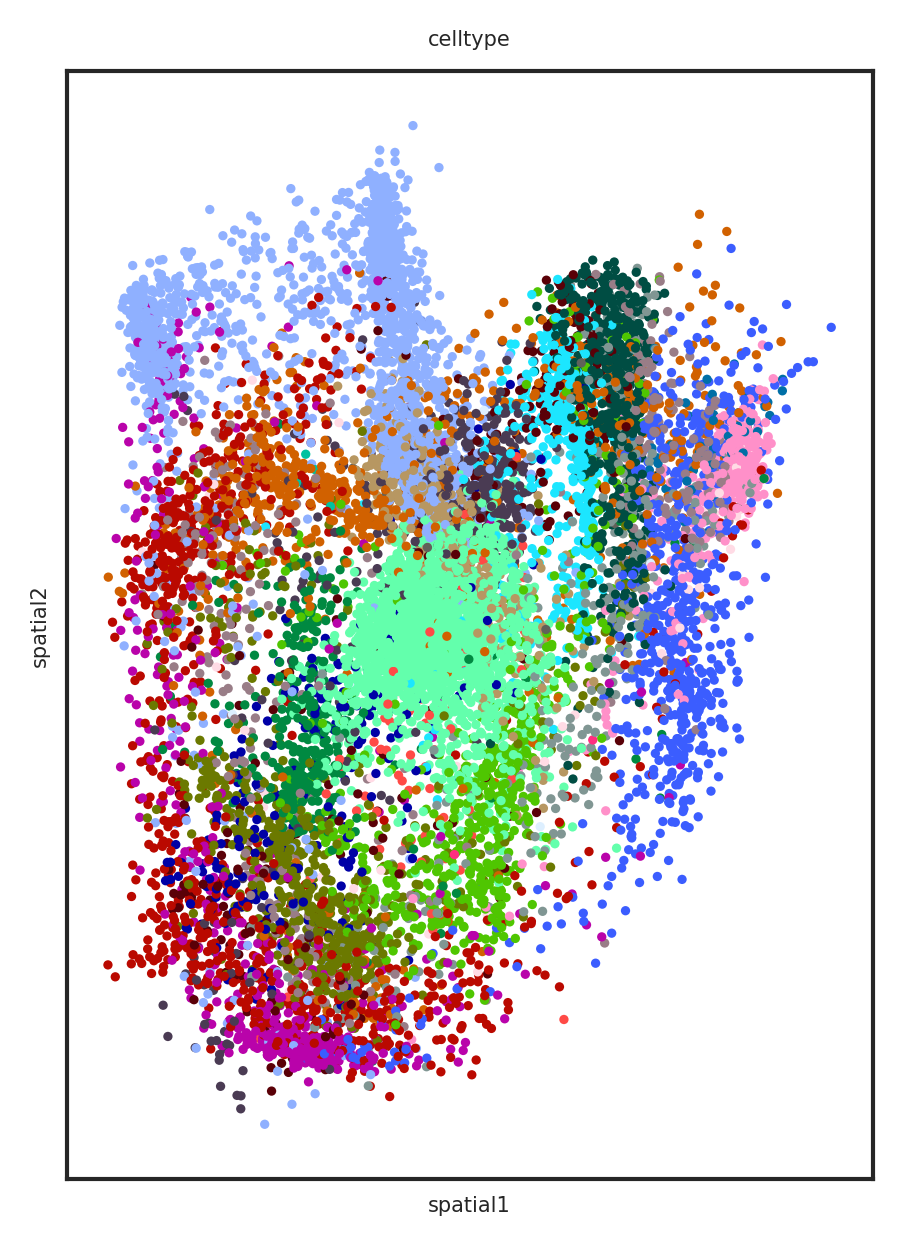

In [21]:
sc_change = {'Blood progenitors 1': "Blood progenitors", 'Blood progenitors 2': "Blood progenitors", 
             'Erythroid1': 'Erythroid', 'Erythroid2':'Erythroid', 'Erythroid3': 'Erythroid' }
our_seq.obs["celltype"] = our_seq.obs["celltype"].replace(sc_change)
sc.pl.spatial(our_seq, color="celltype",palette=_palette, spot_size=0.07, legend_loc=None) 

In [22]:
our_spatial.write_h5ad("ST_recovery_ME.h5ad")
our_seq.write_h5ad("SC_recovery_ME.h5ad")

### For every given cell, calculate the KNN spots that belong to the same cell-type as the cell

In [89]:
# here we only select the shared common celltype for both scRNA-seq and ST
common_celltype = set(our_spatial.obs["celltype_mapped_refined"]).intersection(set(our_seq.obs["celltype"]))

obsm_spatial = np.concatenate([our_seq.obsm["spatial"], our_spatial.obsm["infer_spatial"]])
adata_pos = anndata.AnnData(obsm_spatial)

adata_pos.obs["celltype"] = np.concatenate([our_seq.obs["celltype"], our_spatial.obs["celltype_mapped_refined"]])
adata_pos.obs['celltype'] = pd.Categorical(adata_pos.obs['celltype'])
adata_pos.obs["modal"] = (["seq"] * our_seq.shape[0]) + (["spatial"] * our_spatial.shape[0])

# Convert discrete labels to numerical labels
label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(adata_concat_envi.obs['celltype'])
y = label_encoder.fit_transform(adata_pos.obs['celltype'])

adata_pos.obs["celltype_label"] = y

# Number of neighbors
k = 10

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=k) # default: euclidian

adata_pos_st = adata_pos[adata_pos.obs['modal']=='spatial',:]
adata_pos_sc = adata_pos[adata_pos.obs['modal']=='seq',:]

# Fit the model (using the same data here for simplicity)
knn.fit(adata_pos_st.X, adata_pos_st.obs['celltype_label'])

# Find the k-neighbors for every single cell in scRNA-seq
distances, indices = knn.kneighbors(adata_pos_sc.X)

# Calculate the proportion of neighbors in ST belonging to the same celltype for each cell
proportions = []
celltype_label_ST = adata_pos_st.obs["celltype_label"]
celltype_label_SC = adata_pos_sc.obs["celltype_label"]

for i in range(len(adata_pos_sc.X)):
    # Get the labels of the k-neighbors
    neighbor_labels = celltype_label_ST.iloc[indices[i]]
    # Calculate the proportion of neighbors with the same class as the sample
    proportion = np.sum(neighbor_labels == celltype_label_SC.iloc[i]) / k
    proportions.append(proportion)

adata_pos_sc.obs['KNN_10_fraction_inST'] = proportions
#adata_pos_sc.obs['celltype'] = pd.Categorical(adata_pos_sc.obs['celltype'])

/tmp/ipykernel_779314/23844975.py:45: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_pos_sc.obs['KNN_10_fraction_inST'] = proportions


/media/xiangyu/anaconda3/envs/scvi/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


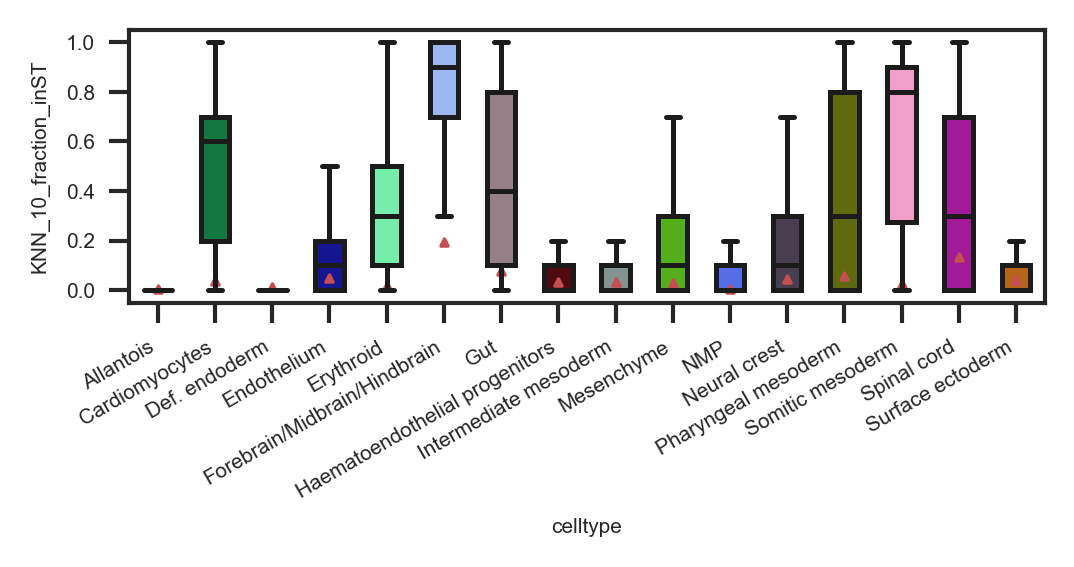

In [90]:
df = adata_pos_sc.obs[['celltype', 'KNN_10_fraction_inST']]
subset_df = df[df['celltype'].isin(common_celltype)]
subset_df = subset_df.reset_index(drop=True)
categories_to_remove = set(adata_pos_sc.obs["celltype"]) - common_celltype
subset_df['celltype'] = subset_df['celltype'].cat.remove_categories(list(categories_to_remove))
ground_truth = (adata_pos_st.obs['celltype'].value_counts()/len(adata_pos_st)).to_dict()

fig, ax = plt.subplots(figsize=(10*centimeter, 3*centimeter))

sns.boxplot(x='celltype', y='KNN_10_fraction_inST', data=subset_df, ax=ax, palette=_palette, dodge=False, width=0.5, showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

ordered_celltype = subset_df['celltype'].cat.categories.values

for celltype in ordered_celltype:
    ax.scatter([celltype], [ground_truth[celltype]], s=3, marker="^", color="r") #, edgecolors="black"

In [53]:
adata_pos_sc.obs['KNN_10_fraction_inST'].mean()

0.28942092682550696

In [54]:
df.groupby(["celltype"]).mean().sort_values(by='KNN_10_fraction_inST', ascending=False)

,KNN_10_fraction_inST
celltype,
Forebrain/Midbrain/Hindbrain,0.802715
Somitic mesoderm,0.622877
Cardiomyocytes,0.486464
Gut,0.447396
Pharyngeal mesoderm,0.390169
Spinal cord,0.363937
Erythroid,0.321826
Neural crest,0.193833
Mesenchyme,0.170783


In [62]:
subset_df.groupby(["celltype"]).mean().sort_values(by='KNN_10_fraction_inST', ascending=False)

/tmp/ipykernel_779314/3710614337.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subset_df.groupby(["celltype"]).mean().sort_values(by='KNN_10_fraction_inST', ascending=False)


,KNN_10_fraction_inST
celltype,
Forebrain/Midbrain/Hindbrain,0.802715
Somitic mesoderm,0.622877
Cardiomyocytes,0.486464
Gut,0.447396
Pharyngeal mesoderm,0.390169
Spinal cord,0.363937
Erythroid,0.321826
Neural crest,0.193833
Mesenchyme,0.170783


In [86]:
adata_pos_st.obs['celltype'].value_counts()/len(adata_pos_st)

celltype
Forebrain/Midbrain/Hindbrain      0.192637
Spinal cord                       0.135718
Low quality                       0.085849
Gut                               0.075614
Lateral plate mesoderm            0.062663
Pharyngeal mesoderm               0.058381
Endothelium                       0.047885
Neural crest                      0.047102
Surface ectoderm                  0.041201
Cardiomyocytes                    0.037963
Intermediate mesoderm             0.032010
Haematoendothelial progenitors    0.031540
Mesenchyme                        0.027885
Cranial mesoderm                  0.027258
Dermomyotome                      0.026893
Somitic mesoderm                  0.023342
Erythroid                         0.015561
Def. endoderm                     0.011070
Anterior somitic tissues          0.005744
NMP                               0.005692
Sclerotome                        0.004073
Allantois                         0.003916
Name: count, dtype: float64

In [88]:
adata_pos_sc.obs['celltype'].value_counts()/len(adata_pos_sc)

celltype
Erythroid                         0.181587
Forebrain/Midbrain/Hindbrain      0.147660
Paraxial mesoderm                 0.070784
Surface ectoderm                  0.058524
NMP                               0.054977
ExE mesoderm                      0.052047
Mesenchyme                        0.051199
Pharyngeal mesoderm               0.050197
Spinal cord                       0.044259
Allantois                         0.039633
ExE endoderm                      0.035315
Neural crest                      0.035007
Somitic mesoderm                  0.032693
Gut                               0.029609
Cardiomyocytes                    0.027913
Intermediate mesoderm             0.027759
Haematoendothelial progenitors    0.024212
Endothelium                       0.018737
Blood progenitors                 0.006169
Def. endoderm                     0.004704
Caudal Mesoderm                   0.004318
PGC                               0.001311
Rostral neurectoderm              0.000617
Vi